In [3]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliisabethein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
torch.manual_seed(1)
np.random.seed(1)

### Functions

In [5]:
def load_data(filename, max_sentence_len):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename) as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [6]:
def tokenize_sentence(string, max_sentence_len):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    return sentence, padded_sentence

In [7]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Load Penn Treebank data

In [8]:
# max_sentence_length = 50
# train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
# val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
# test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

### Load Synthetic data

In [9]:
test_syn_data = np.loadtxt('./synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('./synthetic-data/synthetic_train.txt', dtype=int)

In [10]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)

### Encoder-decoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.embed.weight, -0.1, 0.1)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [12]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.embed.weight, -0.1, 0.1)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden

### VAE

In [49]:
class Stochastic(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(Stochastic, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated, mean, log_variance

In [63]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic = Stochastic(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, x):
        return self.stochastic.latent_to_hidden(x)
        
    def decode(self, hidden, x, x_lens=None, train=True):
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        hidden_concatenated, mean, log_variance = self.stochastic(hidden_concatenated)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs

In [33]:
# # old VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.decoder = Decoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs

#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
#         mean = self.hidden_to_mean(hidden_concatenated)
        
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden = self.latent_to_hidden(z)
        
#         hidden = torch.split(hidden, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [58]:
def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
    BCE = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) 
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    BCE = BCE / mean.shape[1]  # divide by batch size
    KLD = (kl_weight * KLD) / mean.shape[1]
    loss = BCE + KLD
    if annealing_args is not None:
        return loss, BCE, KLD, kl_weight
    else:
        return loss, BCE, KLD
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

### True posterior

In [37]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [84]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, iteration=None):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    approximate_mean, _, _ = vae(tracked_inputs)
    plt.figure(figsize=(5,5))
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true postrior mean")
    plt.ylabel("approximate posterior mean")
    if iteration is not None:
        plt.title("iteration {0}".format(iteration))
    plt.show()

def plot_kl(kl_terms, kl_weights):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(x_axis, kl_terms[::plot_step], label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="orange", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_losses(total_loss, ce_loss, kl_loss):
    plot_step = 10
    x_axis = np.arange(len(total_loss[::plot_step])) * plot_step
    total_loss = np.array(total_loss[::plot_step])
    kl_loss = np.array(kl_loss[::plot_step])
    fig, ax1 = plt.subplots(figsize=(8,4))
    plt.fill_between(x_axis, np.zeros(len(x_axis)), total_loss, label="total loss")
    plt.fill_between(x_axis, np.zeros(len(x_axis)), kl_loss, label="kl loss")
    plt.xlabel("loss")
    plt.ylabel("iteration")
    plt.legend()
    plt.show()

## Experiments

In [79]:
def train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, input_lens=None, synthetic=False, 
          num_layers=1, step=1.0, learning_rate=0.001, tracked_inputs=None, tracked_targets=None, annealing_args=None, 
          aggressive_args=None, plot=False, plot_lim=1.5, verbose=True):
    
#     enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#     stoch_optimizer = torch.optim.Adam(vae.stochastic.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#     dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = 0
    total_losses = []
    ce_losses = []
    kl_losses = []
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
        
    for epoch in range(epochs):        
        for i in range(len(inputs)):
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None
                
            mean, log_variance, outputs = vae(x, x_lens=x_lens)
            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]

            loss_summary = loss_function(outputs, y, mean, log_variance, annealing_args=annealing_args)
            total_losses.append(loss_summary[0].data.item())
            ce_losses.append(loss_summary[1].data.item())
            kl_losses.append(loss_summary[2].data.item())
            
            loss = loss_summary[0]
            
            if annealing_args is not None:
                kl_terms.append(loss_summary[2].data.item())
                kl_weights.append(loss_summary[3])
            
#             enc_optimizer.zero_grad()
#             stoch_optimizer.zero_grad()
#             dec_optimizer.zero_grad()
            vae_optimizer.zero_grad()
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
#             dec_optimizer.step()
#             stoch_optimizer.step()
#             enc_optimizer.step()
            vae_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                if annealing_args is not None:
                    print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weight {:.3f}'.format(epoch+1, 
                                iteration, loss_summary[0].data.item(), loss_summary[1].data.item(),
                                loss_summary[2].data.item(), loss_summary[3]))
                else:
                    print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f}'.format(epoch+1, 
                                iteration, loss_summary[0].data.item(), loss_summary[1].data.item(), 
                                loss_summary[2].data.item()))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration

        if (epoch % 1 == 0) and plot:
            plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
       
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}\n'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))
    
    if annealing_args is not None:
        plot_kl(kl_terms, kl_weights)
    plot_losses(total_losses, ce_losses, kl_losses)

### Synthetic data

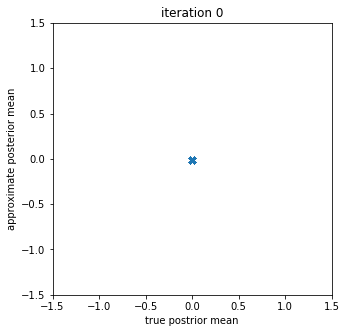

epoch 1 iteration 0 loss 62.167 CE 994.669 KL 0.001
epoch 1 iteration 100 loss 45.931 CE 734.891 KL 0.000
epoch 1 iteration 200 loss 45.410 CE 726.564 KL 0.001
epoch 1 iteration 300 loss 42.745 CE 683.921 KL 0.003
epoch 1 iteration 400 loss 45.515 CE 728.242 KL 0.000
epoch 1 iteration 500 loss 42.770 CE 684.306 KL 0.009
epoch 1 iteration 600 loss 48.231 CE 771.698 KL 0.001
epoch 1 iteration 700 loss 43.342 CE 693.471 KL 0.005
epoch 1 iteration 800 loss 42.138 CE 674.211 KL 0.003
epoch 1 iteration 900 loss 38.712 CE 619.381 KL 0.003


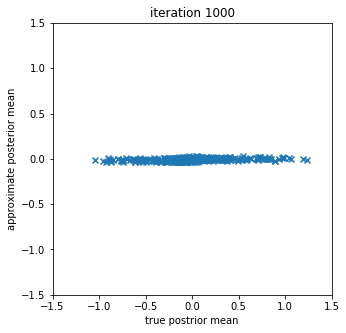

Epoch [1/10], Loss: 40.3482, Perplexity: 333432556522710080.00

epoch 2 iteration 1000 loss 45.697 CE 731.155 KL 0.003
epoch 2 iteration 1100 loss 39.494 CE 631.910 KL 0.001
epoch 2 iteration 1200 loss 40.237 CE 643.797 KL 0.001
epoch 2 iteration 1300 loss 36.390 CE 582.236 KL 0.006
epoch 2 iteration 1400 loss 39.259 CE 628.145 KL 0.001
epoch 2 iteration 1500 loss 34.016 CE 544.261 KL 0.000
epoch 2 iteration 1600 loss 43.325 CE 693.203 KL 0.002
epoch 2 iteration 1700 loss 35.526 CE 568.408 KL 0.000
epoch 2 iteration 1800 loss 38.173 CE 610.775 KL 0.000
epoch 2 iteration 1900 loss 34.698 CE 555.174 KL 0.000


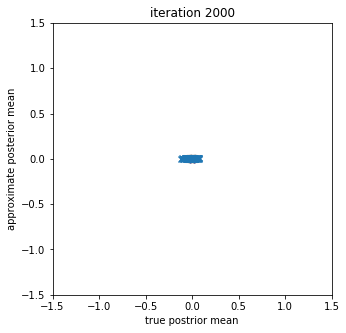

Epoch [2/10], Loss: 35.5735, Perplexity: 2814450824785790.50

epoch 3 iteration 2000 loss 40.332 CE 645.311 KL 0.000
epoch 3 iteration 2100 loss 34.559 CE 552.945 KL 0.001
epoch 3 iteration 2200 loss 35.676 CE 570.814 KL 0.000
epoch 3 iteration 2300 loss 32.410 CE 518.556 KL 0.001
epoch 3 iteration 2400 loss 36.499 CE 583.980 KL 0.001
epoch 3 iteration 2500 loss 32.476 CE 519.620 KL 0.001
epoch 3 iteration 2600 loss 41.904 CE 670.457 KL 0.001
epoch 3 iteration 2700 loss 33.650 CE 538.400 KL 0.000
epoch 3 iteration 2800 loss 36.955 CE 591.274 KL 0.000
epoch 3 iteration 2900 loss 33.363 CE 533.801 KL 0.003


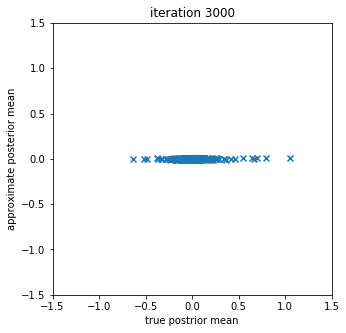

Epoch [3/10], Loss: 34.6511, Perplexity: 1118887857808935.25

epoch 4 iteration 3000 loss 39.763 CE 636.209 KL 0.000
epoch 4 iteration 3100 loss 32.947 CE 527.151 KL 0.002
epoch 4 iteration 3200 loss 34.681 CE 554.891 KL 0.000
epoch 4 iteration 3300 loss 31.306 CE 500.893 KL 0.002
epoch 4 iteration 3400 loss 35.509 CE 568.143 KL 0.001
epoch 4 iteration 3500 loss 31.259 CE 500.137 KL 0.000
epoch 4 iteration 3600 loss 41.112 CE 657.797 KL 0.002
epoch 4 iteration 3700 loss 32.643 CE 522.293 KL 0.001
epoch 4 iteration 3800 loss 35.944 CE 575.096 KL 0.001
epoch 4 iteration 3900 loss 33.047 CE 528.743 KL 0.002


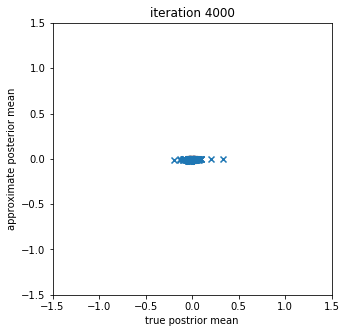

Epoch [4/10], Loss: 33.5600, Perplexity: 375766828204392.88

epoch 5 iteration 4000 loss 38.759 CE 620.141 KL 0.001
epoch 5 iteration 4100 loss 32.136 CE 514.166 KL 0.002
epoch 5 iteration 4200 loss 33.740 CE 539.836 KL 0.002
epoch 5 iteration 4300 loss 30.515 CE 488.244 KL 0.002
epoch 5 iteration 4400 loss 34.337 CE 549.390 KL 0.002
epoch 5 iteration 4500 loss 30.064 CE 481.027 KL 0.000
epoch 5 iteration 4600 loss 39.936 CE 638.972 KL 0.001
epoch 5 iteration 4700 loss 31.760 CE 508.165 KL 0.000
epoch 5 iteration 4800 loss 34.371 CE 549.934 KL 0.000
epoch 5 iteration 4900 loss 32.637 CE 522.196 KL 0.000


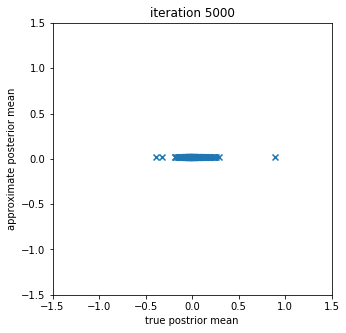

Epoch [5/10], Loss: 32.7821, Perplexity: 172609839610154.97

epoch 6 iteration 5000 loss 38.011 CE 608.172 KL 0.006
epoch 6 iteration 5100 loss 31.812 CE 508.999 KL 0.000
epoch 6 iteration 5200 loss 33.164 CE 530.625 KL 0.001
epoch 6 iteration 5300 loss 29.709 CE 475.343 KL 0.001
epoch 6 iteration 5400 loss 33.526 CE 536.413 KL 0.003
epoch 6 iteration 5500 loss 29.397 CE 470.356 KL 0.001
epoch 6 iteration 5600 loss 39.376 CE 630.018 KL 0.001
epoch 6 iteration 5700 loss 30.769 CE 492.303 KL 0.001
epoch 6 iteration 5800 loss 33.410 CE 534.564 KL 0.000
epoch 6 iteration 5900 loss 32.451 CE 519.218 KL 0.000


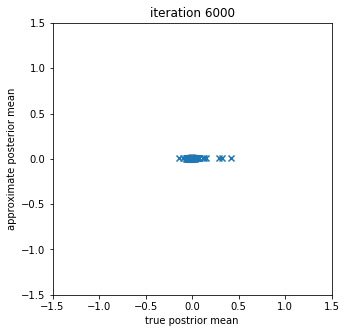

Epoch [6/10], Loss: 32.2986, Perplexity: 106442895069440.70

epoch 7 iteration 6000 loss 37.376 CE 598.020 KL 0.000
epoch 7 iteration 6100 loss 31.309 CE 500.940 KL 0.001
epoch 7 iteration 6200 loss 32.888 CE 526.207 KL 0.000
epoch 7 iteration 6300 loss 28.991 CE 463.859 KL 0.003
epoch 7 iteration 6400 loss 32.772 CE 524.344 KL 0.001
epoch 7 iteration 6500 loss 28.998 CE 463.967 KL 0.001
epoch 7 iteration 6600 loss 38.949 CE 623.174 KL 0.003
epoch 7 iteration 6700 loss 30.197 CE 483.147 KL 0.001
epoch 7 iteration 6800 loss 32.905 CE 526.480 KL 0.000
epoch 7 iteration 6900 loss 32.215 CE 515.433 KL 0.001


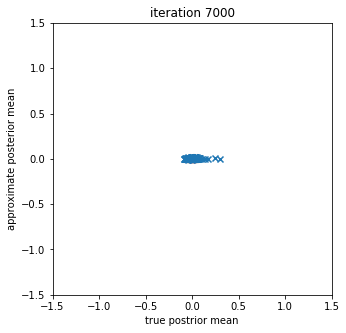

Epoch [7/10], Loss: 31.9402, Perplexity: 74379307814755.81

epoch 8 iteration 7000 loss 36.837 CE 589.397 KL 0.000
epoch 8 iteration 7100 loss 30.774 CE 492.379 KL 0.002
epoch 8 iteration 7200 loss 32.545 CE 520.718 KL 0.000
epoch 8 iteration 7300 loss 28.514 CE 456.219 KL 0.001
epoch 8 iteration 7400 loss 32.049 CE 512.791 KL 0.001
epoch 8 iteration 7500 loss 28.698 CE 459.163 KL 0.000
epoch 8 iteration 7600 loss 38.737 CE 619.773 KL 0.014
epoch 8 iteration 7700 loss 29.972 CE 479.557 KL 0.001
epoch 8 iteration 7800 loss 32.622 CE 521.946 KL 0.000
epoch 8 iteration 7900 loss 31.930 CE 510.876 KL 0.002


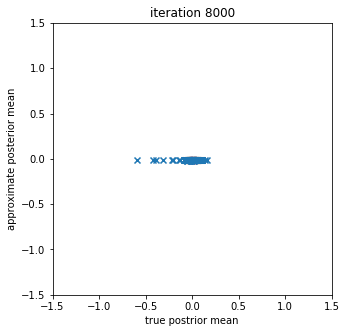

Epoch [8/10], Loss: 31.6877, Perplexity: 57779682151354.27

epoch 9 iteration 8000 loss 36.408 CE 582.529 KL 0.002
epoch 9 iteration 8100 loss 30.428 CE 486.852 KL 0.003
epoch 9 iteration 8200 loss 32.255 CE 516.086 KL 0.001
epoch 9 iteration 8300 loss 28.175 CE 450.802 KL 0.001
epoch 9 iteration 8400 loss 31.540 CE 504.642 KL 0.005
epoch 9 iteration 8500 loss 28.524 CE 456.387 KL 0.000
epoch 9 iteration 8600 loss 38.575 CE 617.200 KL 0.000
epoch 9 iteration 8700 loss 29.790 CE 476.616 KL 0.022
epoch 9 iteration 8800 loss 32.358 CE 517.725 KL 0.001
epoch 9 iteration 8900 loss 31.663 CE 506.607 KL 0.001


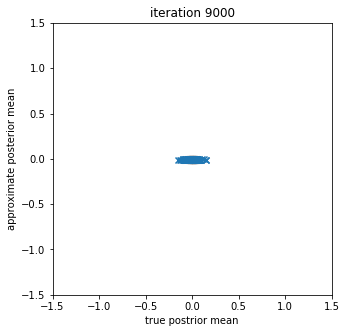

Epoch [9/10], Loss: 31.4577, Perplexity: 45910984812780.88

epoch 10 iteration 9000 loss 36.229 CE 579.661 KL 0.001
epoch 10 iteration 9100 loss 30.156 CE 482.496 KL 0.004
epoch 10 iteration 9200 loss 32.038 CE 512.592 KL 0.012
epoch 10 iteration 9300 loss 27.986 CE 447.764 KL 0.004
epoch 10 iteration 9400 loss 31.282 CE 500.504 KL 0.000
epoch 10 iteration 9500 loss 28.344 CE 453.500 KL 0.000
epoch 10 iteration 9600 loss 38.067 CE 609.078 KL 0.002
epoch 10 iteration 9700 loss 29.613 CE 473.808 KL 0.002
epoch 10 iteration 9800 loss 32.204 CE 515.257 KL 0.000
epoch 10 iteration 9900 loss 31.343 CE 501.478 KL 0.003


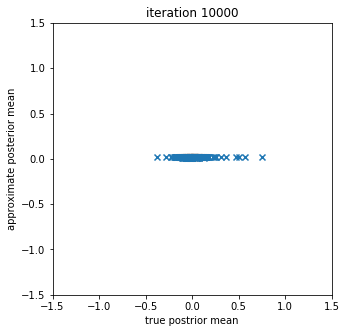

Epoch [10/10], Loss: 31.2219, Perplexity: 36265001171962.35



In [44]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5)

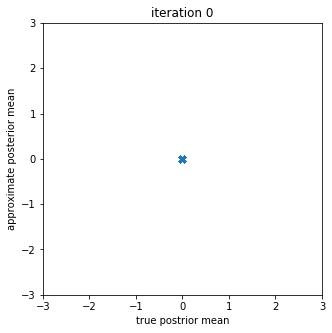

epoch 1 iteration 0 loss 62.169 CE 994.700 KL 0.000 weight 0.002
epoch 1 iteration 100 loss 46.052 CE 736.787 KL 20.386 weight 0.002
epoch 1 iteration 200 loss 45.365 CE 725.785 KL 17.576 weight 0.003
epoch 1 iteration 300 loss 42.720 CE 683.452 KL 17.559 weight 0.004
epoch 1 iteration 400 loss 45.666 CE 730.612 KL 8.811 weight 0.005
epoch 1 iteration 500 loss 42.750 CE 683.920 KL 11.116 weight 0.007
epoch 1 iteration 600 loss 48.069 CE 769.018 KL 10.512 weight 0.009
epoch 1 iteration 700 loss 42.056 CE 672.606 KL 26.491 weight 0.011
epoch 1 iteration 800 loss 39.645 CE 633.853 KL 32.778 weight 0.014
epoch 1 iteration 900 loss 38.653 CE 617.861 KL 32.231 weight 0.018


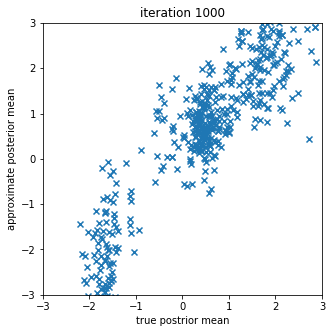

Epoch [1/10], Loss: 37.5268, Perplexity: 19847217382208548.00

epoch 2 iteration 1000 loss 44.552 CE 711.746 KL 47.429 weight 0.023
epoch 2 iteration 1100 loss 37.000 CE 590.028 KL 67.280 weight 0.029
epoch 2 iteration 1200 loss 38.005 CE 606.780 KL 34.801 weight 0.037
epoch 2 iteration 1300 loss 33.817 CE 537.881 KL 67.391 weight 0.047
epoch 2 iteration 1400 loss 36.566 CE 582.732 KL 38.683 weight 0.060
epoch 2 iteration 1500 loss 31.935 CE 508.150 KL 37.138 weight 0.076
epoch 2 iteration 1600 loss 39.562 CE 628.711 KL 44.820 weight 0.095
epoch 2 iteration 1700 loss 38.498 CE 611.028 KL 41.377 weight 0.119
epoch 2 iteration 1800 loss 34.478 CE 545.074 KL 44.375 weight 0.148
epoch 2 iteration 1900 loss 33.300 CE 525.864 KL 38.004 weight 0.182


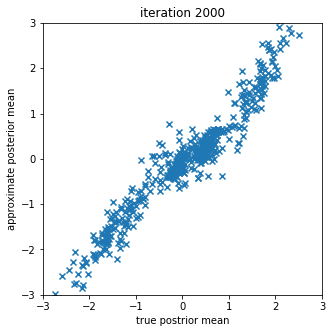

Epoch [2/10], Loss: 34.2063, Perplexity: 717111929015220.12

epoch 3 iteration 2000 loss 41.404 CE 654.320 KL 36.602 weight 0.223
epoch 3 iteration 2100 loss 33.876 CE 532.200 KL 36.521 weight 0.269
epoch 3 iteration 2200 loss 34.341 CE 538.915 KL 32.870 weight 0.321
epoch 3 iteration 2300 loss 32.650 CE 507.964 KL 38.228 weight 0.378
epoch 3 iteration 2400 loss 36.023 CE 562.473 KL 31.744 weight 0.438
epoch 3 iteration 2500 loss 31.212 CE 485.274 KL 28.238 weight 0.500
epoch 3 iteration 2600 loss 39.816 CE 621.036 KL 28.503 weight 0.562
epoch 3 iteration 2700 loss 33.594 CE 520.562 KL 27.206 weight 0.622
epoch 3 iteration 2800 loss 34.469 CE 532.384 KL 28.155 weight 0.679
epoch 3 iteration 2900 loss 33.423 CE 514.724 KL 27.408 weight 0.731


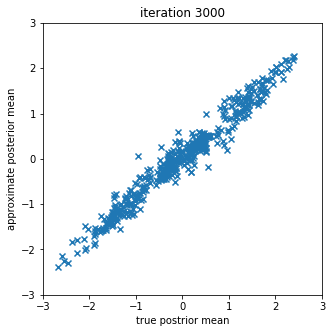

Epoch [3/10], Loss: 33.7126, Perplexity: 437726747207313.62

epoch 4 iteration 3000 loss 39.937 CE 619.312 KL 25.321 weight 0.777
epoch 4 iteration 3100 loss 33.515 CE 514.378 KL 26.742 weight 0.818
epoch 4 iteration 3200 loss 34.128 CE 524.897 KL 24.822 weight 0.852
epoch 4 iteration 3300 loss 31.701 CE 481.401 KL 29.303 weight 0.881
epoch 4 iteration 3400 loss 35.920 CE 553.444 KL 23.511 weight 0.905
epoch 4 iteration 3500 loss 31.360 CE 480.703 KL 22.791 weight 0.924
epoch 4 iteration 3600 loss 39.081 CE 600.167 KL 26.730 weight 0.940
epoch 4 iteration 3700 loss 33.467 CE 514.007 KL 22.536 weight 0.953
epoch 4 iteration 3800 loss 34.796 CE 530.655 KL 27.095 weight 0.963
epoch 4 iteration 3900 loss 33.270 CE 509.017 KL 24.004 weight 0.971


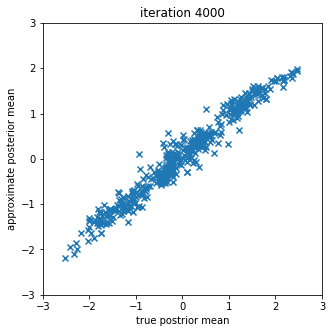

Epoch [4/10], Loss: 33.0480, Perplexity: 225207270737471.19

epoch 5 iteration 4000 loss 39.147 CE 605.781 KL 21.050 weight 0.977
epoch 5 iteration 4100 loss 31.850 CE 486.874 KL 23.135 weight 0.982
epoch 5 iteration 4200 loss 35.085 CE 538.452 KL 23.241 weight 0.986
epoch 5 iteration 4300 loss 32.026 CE 485.782 KL 26.935 weight 0.989
epoch 5 iteration 4400 loss 34.633 CE 532.754 KL 21.559 weight 0.991
epoch 5 iteration 4500 loss 30.154 CE 461.028 KL 21.584 weight 0.993
epoch 5 iteration 4600 loss 38.131 CE 585.422 KL 24.801 weight 0.995
epoch 5 iteration 4700 loss 33.591 CE 515.400 KL 22.141 weight 0.996
epoch 5 iteration 4800 loss 34.343 CE 526.164 KL 23.397 weight 0.997
epoch 5 iteration 4900 loss 32.601 CE 499.428 KL 22.246 weight 0.998


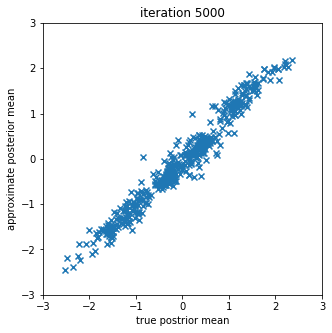

Epoch [5/10], Loss: 33.0432, Perplexity: 224112870930022.75

epoch 6 iteration 5000 loss 39.142 CE 605.998 KL 20.306 weight 0.998
epoch 6 iteration 5100 loss 31.686 CE 484.535 KL 22.480 weight 0.998
epoch 6 iteration 5200 loss 33.663 CE 516.998 KL 21.630 weight 0.999
epoch 6 iteration 5300 loss 31.633 CE 480.901 KL 25.244 weight 0.999
epoch 6 iteration 5400 loss 34.750 CE 535.833 KL 20.177 weight 0.999
epoch 6 iteration 5500 loss 29.332 CE 447.965 KL 21.357 weight 0.999
epoch 6 iteration 5600 loss 37.247 CE 574.094 KL 21.870 weight 1.000
epoch 6 iteration 5700 loss 31.384 CE 480.564 KL 21.587 weight 1.000
epoch 6 iteration 5800 loss 33.160 CE 509.672 KL 20.901 weight 1.000
epoch 6 iteration 5900 loss 32.152 CE 492.577 KL 21.859 weight 1.000


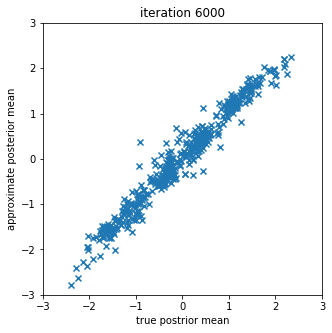

Epoch [6/10], Loss: 32.2555, Perplexity: 101953601700273.95

epoch 7 iteration 6000 loss 39.301 CE 608.709 KL 20.105 weight 1.000
epoch 7 iteration 6100 loss 30.383 CE 464.189 KL 21.934 weight 1.000
epoch 7 iteration 6200 loss 33.492 CE 514.635 KL 21.232 weight 1.000
epoch 7 iteration 6300 loss 29.756 CE 450.824 KL 25.270 weight 1.000
epoch 7 iteration 6400 loss 33.115 CE 511.161 KL 18.680 weight 1.000
epoch 7 iteration 6500 loss 29.196 CE 446.617 KL 20.522 weight 1.000
epoch 7 iteration 6600 loss 37.684 CE 580.214 KL 22.723 weight 1.000
epoch 7 iteration 6700 loss 31.600 CE 484.173 KL 21.434 weight 1.000
epoch 7 iteration 6800 loss 32.557 CE 497.338 KL 23.573 weight 1.000
epoch 7 iteration 6900 loss 31.398 CE 481.636 KL 20.731 weight 1.000


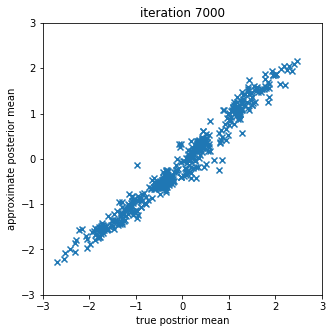

Epoch [7/10], Loss: 31.7289, Perplexity: 60214326821798.26

epoch 8 iteration 7000 loss 38.603 CE 597.608 KL 20.036 weight 1.000
epoch 8 iteration 7100 loss 30.403 CE 465.915 KL 20.526 weight 1.000
epoch 8 iteration 7200 loss 32.249 CE 494.222 KL 21.758 weight 1.000
epoch 8 iteration 7300 loss 29.931 CE 454.397 KL 24.505 weight 1.000
epoch 8 iteration 7400 loss 32.674 CE 502.192 KL 20.594 weight 1.000
epoch 8 iteration 7500 loss 29.126 CE 446.075 KL 19.938 weight 1.000
epoch 8 iteration 7600 loss 37.195 CE 573.917 KL 21.197 weight 1.000
epoch 8 iteration 7700 loss 30.666 CE 470.026 KL 20.629 weight 1.000
epoch 8 iteration 7800 loss 32.533 CE 499.209 KL 21.326 weight 1.000
epoch 8 iteration 7900 loss 31.420 CE 481.844 KL 20.883 weight 1.000


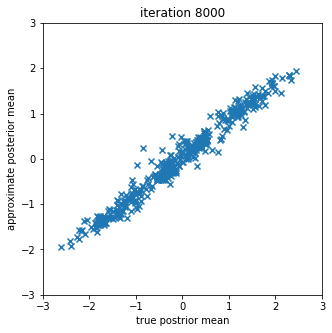

Epoch [8/10], Loss: 31.8575, Perplexity: 68474134278284.16

epoch 9 iteration 8000 loss 37.804 CE 585.622 KL 19.241 weight 1.000
epoch 9 iteration 8100 loss 29.748 CE 454.963 KL 21.011 weight 1.000
epoch 9 iteration 8200 loss 31.928 CE 489.698 KL 21.150 weight 1.000
epoch 9 iteration 8300 loss 30.038 CE 457.328 KL 23.286 weight 1.000
epoch 9 iteration 8400 loss 32.089 CE 493.727 KL 19.697 weight 1.000
epoch 9 iteration 8500 loss 29.092 CE 444.430 KL 21.041 weight 1.000
epoch 9 iteration 8600 loss 36.785 CE 567.662 KL 20.903 weight 1.000
epoch 9 iteration 8700 loss 29.902 CE 458.191 KL 20.246 weight 1.000
epoch 9 iteration 8800 loss 31.454 CE 482.572 KL 20.686 weight 1.000
epoch 9 iteration 8900 loss 31.338 CE 481.422 KL 19.988 weight 1.000


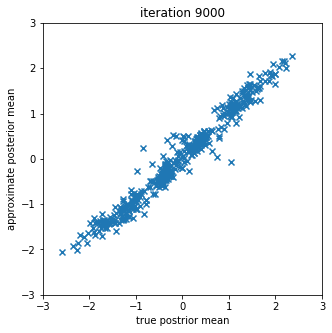

Epoch [9/10], Loss: 31.0751, Perplexity: 31315738254577.34

epoch 10 iteration 9000 loss 37.473 CE 579.704 KL 19.869 weight 1.000
epoch 10 iteration 9100 loss 29.230 CE 448.038 KL 19.637 weight 1.000
epoch 10 iteration 9200 loss 32.328 CE 496.550 KL 20.700 weight 1.000
epoch 10 iteration 9300 loss 28.939 CE 439.049 KL 23.970 weight 1.000
epoch 10 iteration 9400 loss 31.283 CE 481.673 KL 18.849 weight 1.000
epoch 10 iteration 9500 loss 28.864 CE 441.679 KL 20.139 weight 1.000
epoch 10 iteration 9600 loss 36.908 CE 569.513 KL 21.008 weight 1.000
epoch 10 iteration 9700 loss 30.061 CE 461.902 KL 19.074 weight 1.000
epoch 10 iteration 9800 loss 31.384 CE 481.337 KL 20.814 weight 1.000
epoch 10 iteration 9900 loss 31.492 CE 482.995 KL 20.883 weight 1.000


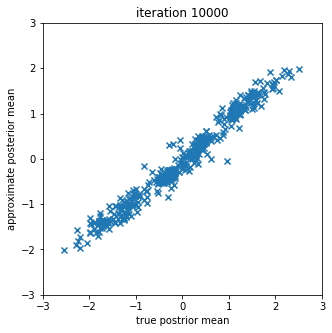

Epoch [10/10], Loss: 30.7642, Perplexity: 22945938465636.75



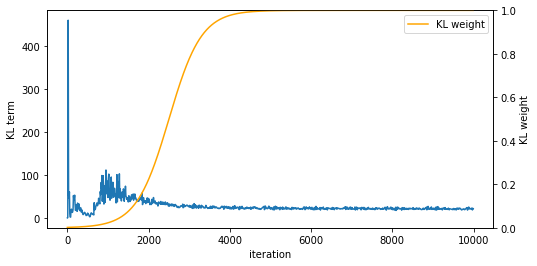

In [56]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

# TEXT DATA

### Create Word2Vec word embeddings

In [6]:
embedding_size = 500
num_epochs_to_train = 10

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=num_epochs_to_train, total_examples=word2vec_model.corpus_count)

word2vec_model.wv.most_similar("stocks")
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
print("size of the vocabulary:", vocabulary_size)

### Define RNNLM

In [28]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [5]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 10

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

In [97]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

(1, 4, 1)
Argmax:  the
Next word:  toseland
